In [2]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_curve,fbeta_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegressionCV
import shap
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate  
from scipy import stats
from sklearn.inspection import permutation_importance




# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

# 设置numpy随机种子
np.random.seed(42)


In [3]:
# 从本地读取一个 parquet 文件，并加载为 pandas 的 DataFrame 数据表
# parquet 是一种高效的表格存储格式，比 Excel/CSV 读取更快、占空间更小
df = pd.read_parquet('外呼建模-0708.parquet')
#查看 df 的基本信息
#了解数据的整体情况
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578982 entries, 0 to 578981
Data columns (total 41 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   加密手机号码          578982 non-null  object        
 1   市场确认是否意向        578982 non-null  int64         
 2   是否转化成交          578982 non-null  int64         
 3   资源渠道            578982 non-null  object        
 4   是否接触过卓越         578982 non-null  int64         
 5   是否领过资料          578982 non-null  int64         
 6   首次成交日期_TMS      139 non-null     datetime64[ns]
 7   首次成交金额_TMS      2598 non-null    float64       
 8   首次购买科目_TMS      134 non-null     object        
 9   首次购买科数_TMS      134 non-null     float64       
 10  首次成交日期_EVIP     10 non-null      datetime64[ns]
 11  首次成交金额_EVIP     446 non-null     float64       
 12  首次购买科目_EVIP     9 non-null       object        
 13  首次购买科数_EVIP     446 non-null     float64       
 14  拨打次数            578982 non-null  int

In [19]:
# 第一部分：数据预处理与特征工程

def create_features(df):
    """创建用于机器学习的特征（使用最长通话数据）"""
    
    # 创建副本避免修改原数据
    data = df.copy()
    
    # 1. 基础特征编码
    le = LabelEncoder()
    
    # 编码分类变量
    categorical_features = ['资源渠道', 
                           'long_呼叫时段', 'long_是否工作日', 'long_周几',
                           'long_客户意向_AI', 'long_客户意向_人工']
    
    #遍历指定的类别特征列
    #用 LabelEncoder 把字符串类别转成整数编码
    for col in categorical_features:
        if col in data.columns:
            data[f'{col}_encoded'] = le.fit_transform(data[col].astype(str))
    
    # 2. 衍生特征工程
    # 通话效率特征
    # 分母添加1e-10是为了防止除0
    data['打通率'] = data['打通次数'] / (data['拨打次数'] + 1e-10)
    data['完播率'] = data['利益点完播次数'] / (data['打通次数'] + 1e-10)
    data['长通话率'] = data['通话60s以上次数'] / (data['打通次数'] + 1e-10)
    data['中等通话率'] = (data['通话15-30s次数'] + data['通话30-60s次数']) / (data['打通次数'] + 1e-10)
    
    # 通话质量特征
    data['通话质量分'] = (data['通话30-60s次数'] * 2 + data['通话60s以上次数'] * 3) / (data['打通次数'] + 1e-10)
    data['总通话时长估计'] = (
                         data['通话15-30s次数'] * 22.5 + 
                         data['通话30-60s次数'] * 45 + 
                         data['通话60s以上次数'] * 90)#使用平均值进行估计 
    
    # 客户参与度特征
    data['参与度总分'] = data['打通次数'] + data['利益点完播次数'] * 2 + data['通话60s以上次数'] * 3
    data['平均通话质量'] = data['总通话时长估计'] / (data['打通次数'] + 1e-10)
    
    # 是否为白名单
    data['是否为白名单'] = (data['资源渠道'] == '外部白名单').astype(int)
    
    
    # 基于转化用户特征创建二值化特征
    # 高于下25分位点记为高，是一种更加宽松的定义
    data['高打通率'] = (data['打通率'] > data['打通率'].quantile(0.25)).astype(int)
    data['高完播率'] = (data['完播率'] > data['完播率'].quantile(0.25)).astype(int)
    data['高长通话率'] = (data['长通话率'] > data['长通话率'].quantile(0.25)).astype(int)
    data['高参与度'] = (data['参与度总分'] > data['参与度总分'].quantile(0.25)).astype(int)
    
    # 组合特征
    data['转化模式得分'] = (data['高打通率'] + data['高完播率'] + 
                        data['高长通话率'] + data['高参与度'] + 
                        data['市场确认是否意向'])#是否使用市场确认是否意向，我个人觉得可以使用。
    
    # 4. 选择机器学习特征
    feature_columns = [
        # 基础特征
        '拨打次数', '打通次数', '利益点完播次数', '活动通知次数',
         '通话15-30s次数', '通话30-60s次数', '通话60s以上次数','long_通话时长',
        
        # 编码后的分类特征
        '资源渠道_encoded',
        'long_呼叫时段_encoded', 'long_是否工作日_encoded', 'long_周几_encoded',
        'long_客户意向_AI_encoded', 'long_客户意向_人工_encoded',
        
        # 衍生特征
        '打通率', '完播率', '长通话率', '中等通话率',
        '通话质量分', '总通话时长估计', '参与度总分', '平均通话质量',
        '是否为白名单'
        # 
        '高打通率', '高完播率', '高长通话率', '高参与度', '转化模式得分'
    ]
    
    # 过滤存在的特征
    available_features = [col for col in feature_columns if col in data.columns]
    
    X = data[available_features]

    y = data['是否转化成交']
    #通过这里的替换可以建模意向，注意上面的转化模式得分就要把是否意向去掉
    #y = data['市场确认是否意向']
    
    # 处理缺失值
    X = X.fillna(0)

    print(f"总特征数量: {len(available_features)}")
    print(f"新增转化区分特征: 5个")
    
    return X, y, available_features, data

# 执行特征工程
X, y, feature_names, processed_data = create_features(df)

print(f"特征数量: {X.shape[1]}")
print(f"样本数量: {X.shape[0]}")
print(f"正负样本比例: {(y==0).sum()}:{(y==1).sum()} = {(y==0).sum()/(y==1).sum():.1f}:1")


总特征数量: 26
新增转化区分特征: 5个
特征数量: 26
样本数量: 578982
正负样本比例: 578833:149 = 3884.8:1


In [20]:
processed_data 

,加密手机号码,市场确认是否意向,是否转化成交,资源渠道,是否接触过卓越,是否领过资料,首次成交日期_TMS,首次成交金额_TMS,首次购买科目_TMS,首次购买科数_TMS,...,通话质量分,总通话时长估计,参与度总分,平均通话质量,是否为白名单,高打通率,高完播率,高长通话率,高参与度,转化模式得分
0,5892fb0b804b7f50761cc1f0fedc10b6,0,0,外部白名单,0,0,NaT,NaN,None,NaN,...,0.0,0.0,0,0.0,1,0,0,0,0,0
1,589389297cc3c0cb08d010541afa9911,0,0,亲子沉睡激活,1,1,NaT,NaN,None,NaN,...,2.0,45.0,3,45.0,0,1,1,0,1,3
2,5893ada6d8874b40d77994d5da47c6a4,0,0,外部白名单,0,0,NaT,NaN,None,NaN,...,0.0,0.0,0,0.0,1,0,0,0,0,0
3,5893bb8b4e6dcb5101d654f379918f7d,0,0,外部白名单,0,0,NaT,NaN,None,NaN,...,0.0,0.0,0,0.0,1,0,0,0,0,0
4,5893f192716215e7ec1473a8f00489b8,0,0,成长沉睡激活,1,1,NaT,NaN,None,NaN,...,0.0,0.0,0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578977,589288dcdb83c9680ce46e21141a3d15,0,0,成长沉睡激活,1,1,NaT,NaN,None,NaN,...,0.0,0.0,0,0.0,0,0,0,0,0,0
578978,58929204ee730aee9748a94703beac44,0,0,外部白名单,0,0,NaT,NaN,None,NaN,...,0.0,0.0,0,0.0,1,0,0,0,0,0
578979,5892be1a74d4f4f65da1db51979c9fc4,0,0,成长市场,1,1,NaT,NaN,None,NaN,...,0.0,0.0,0,0.0,0,0,0,0,0,0
578980,5892d499799f2d1182b0db8d1f19312b,0,0,tmk资源池,1,1,NaT,NaN,None,NaN,...,0.0,0.0,2,0.0,0,1,0,0,1,2


 ### 第二部分：划分最终验证集（Final Validation Set）
 - 目的：
   - 为了模拟真实业务场景，我们在所有样本中，单独抽出一小部分作为“最终验证集”
   - 验证集数据在模型训练时不会使用，用来最终评估模型效果
   - 验证集正负比例尽量保持和真实业务接近

In [21]:
# 特征工程后，分离最终验证集
# ===============================

# 获取所有正样本的索引
positive_indices = y[y == 1].index.tolist()
print(f"总正样本数量: {len(positive_indices)}")
# 从正样本中随机选择30个作为最终验证集
final_validation_indices = np.random.choice(positive_indices, size=30, replace=False)
training_positive_indices = [idx for idx in positive_indices if idx not in final_validation_indices]

print(f"最终验证集正样本: 30个")
print(f"训练用正样本: {len(training_positive_indices)}个")

# 为最终验证集选择合理数量的负样本
negative_indices = y[y == 0].index.tolist()
# 选择合理的负样本数量：使用原始比例，即116550个负样本
final_validation_negative_count = 116550 
final_validation_negative_indices = np.random.choice(negative_indices, 
                                                   size=final_validation_negative_count, 
                                                   replace=False)

print(f"最终验证集负样本: {final_validation_negative_count}个")
print(f"最终验证集总样本: {30 + final_validation_negative_count}个")
print(f"最终验证集正负比例: 1:{final_validation_negative_count//30}")

# 创建最终验证集
final_validation_all_indices = list(final_validation_indices) + list(final_validation_negative_indices)
X_final_validation = X.loc[final_validation_all_indices]
y_final_validation = y.loc[final_validation_all_indices]

# 从训练数据中移除最终验证集样本（使用更高效的方法）
final_validation_indices_set = set(final_validation_all_indices)
remaining_mask = ~X.index.isin(final_validation_all_indices)
X_training_pool = X[remaining_mask]
y_training_pool = y[remaining_mask]

print(f"数据分布:")
print(f"训练池 - 正样本: {(y_training_pool == 1).sum()}个")
print(f"训练池 - 负样本: {(y_training_pool == 0).sum()}个")
print(f"最终验证集 - 正样本: {(y_final_validation == 1).sum()}个")
print(f"最终验证集 - 负样本: {(y_final_validation == 0).sum()}个")
print(f"最终验证集转化率: {y_final_validation.mean():.6f}")


总正样本数量: 149
最终验证集正样本: 30个
训练用正样本: 119个
最终验证集负样本: 116550个
最终验证集总样本: 116580个
最终验证集正负比例: 1:3885
数据分布:
训练池 - 正样本: 119个
训练池 - 负样本: 462283个
最终验证集 - 正样本: 30个
最终验证集 - 负样本: 116550个
最终验证集转化率: 0.000257


 ### 第三部分：多重欠采样策略
 - 目的：
   - 正负样本极度不平衡，直接训练模型容易偏向负样本（非转化客户）。
   - 通过“欠采样”策略，每次从负样本里随机抽取和正样本数量相同的样本，
   - 构建多个 1:1 平衡数据集，进行交叉验证，提高模型稳健性。
   - 最终会用之前保留的 30 个正样本 + 对应的负样本做最终独立验证。

In [22]:
# 多重欠采样策略：构建多个平衡数据集进行交叉验证（使用119个正样本）

print("多重欠采样平衡数据集构建策略（保留30个正样本作为最终验证）")

def create_multiple_balanced_datasets(X, y, n_datasets=100, positive_sample_multiplier=1):
    """
    创建多个平衡数据集
    
    参数:
    - X: 特征矩阵
    - y: 标签
    - n_datasets: 要创建的数据集数量
    - positive_sample_multiplier: 负样本数量相对于正样本的倍数（1表示1:1平衡）
    - 这里的数字代表不输入的默认值
    """
    
    # 分离正负样本
    positive_indices = np.where(y == 1)[0]
    negative_indices = np.where(y == 0)[0]
    
    n_positive = len(positive_indices)
    n_negative_per_dataset = n_positive * positive_sample_multiplier
    
    print(f"数据分布:")
    print(f"正样本数量: {n_positive}")
    print(f"负样本数量: {len(negative_indices)}")
    print(f"每个数据集负样本抽取: {n_negative_per_dataset}")
    print(f"将创建 {n_datasets} 个平衡数据集")
    
    datasets = []
    
    # 设置随机种子，确保可重现性
    #确保不重复抽样
    for i in range(n_datasets):
        # 随机抽取负样本
        selected_negative_indices = np.random.choice(
            negative_indices, 
            size=n_negative_per_dataset, 
            replace=False
        )
        
        # 合并正负样本索引
        balanced_indices = np.concatenate([positive_indices, selected_negative_indices])
        
        # 创建平衡数据集
        X_balanced = X.iloc[balanced_indices]
        y_balanced = y.iloc[balanced_indices]
        
        datasets.append({
            'X': X_balanced,
            'y': y_balanced,
            'indices': balanced_indices,
            'dataset_id': i + 1
        })
        
        print(f"   数据集 {i+1}: {len(y_balanced)} 样本 (正:{sum(y_balanced)}, 负:{len(y_balanced)-sum(y_balanced)})")
    
    return datasets






# 执行多重欠采样策略（使用训练池数据）
print("开始执行多重欠采样策略...")

# 创建多个平衡数据集（使用剩余的119个正样本）
balanced_datasets = create_multiple_balanced_datasets(
    X_training_pool, y_training_pool, 
    n_datasets=10,  # 创建10个数据集
    positive_sample_multiplier=1  # 1:1 平衡
)


多重欠采样平衡数据集构建策略（保留30个正样本作为最终验证）
开始执行多重欠采样策略...
数据分布:
正样本数量: 119
负样本数量: 462283
每个数据集负样本抽取: 119
将创建 10 个平衡数据集
   数据集 1: 238 样本 (正:119, 负:119)
   数据集 2: 238 样本 (正:119, 负:119)
   数据集 3: 238 样本 (正:119, 负:119)
   数据集 4: 238 样本 (正:119, 负:119)
   数据集 5: 238 样本 (正:119, 负:119)
   数据集 6: 238 样本 (正:119, 负:119)
   数据集 7: 238 样本 (正:119, 负:119)
   数据集 8: 238 样本 (正:119, 负:119)
   数据集 9: 238 样本 (正:119, 负:119)
   数据集 10: 238 样本 (正:119, 负:119)


### **第五部分：在多重欠采样数据集上训练逻辑回归模型**

这一部分是模型训练的核心步骤，我们将在前面构造的 **10 个平衡数据集** 上依次训练逻辑回归模型，并完成以下任务：

1. **特征标准化**  
   - 对每个数据集的特征做 `StandardScaler` 标准化，使模型对不同量纲的特征敏感度一致。

2. **L2 正则化调参**  
   - 使用 `GridSearchCV` 在多个 `C` 参数上网格搜索，目标优化指标是 **F2 分数**（更重视召回率）。
   - L2 正则化可以防止过拟合，让模型在极度不平衡数据上更稳健。

3. **交叉验证评估**  
   - 对每个平衡数据集进行 5 折交叉验证，输出 Accuracy、Precision、Recall、F1、F2、ROC-AUC 等指标均值和标准差。
   - 这样可以判断模型在小样本下的稳定性。

4. **最终模型训练与概率校准**  
   - 用最佳参数训练最终模型。
   - 使用 `CalibratedClassifierCV` 进行 **Platt scaling** 概率校准，提升预测概率的可信度。

5. **SHAP 特征重要性分析**  
   - 使用 `shap.LinearExplainer` 解释模型。
   - 计算每个特征的平均绝对 SHAP 值，衡量特征对预测转化的贡献。

6. **保存模型与分析结果**  
   - 包含模型本身、标准化器、交叉验证指标、SHAP 分析结果，便于后续在最终验证集上做测试。


In [23]:

def train_logistic_regression_on_datasets(datasets, feature_names):
    """
    在多个数据集上训练逻辑回归模型并进行交叉验证
    包含L2正则化、概率校准和SHAP分析
    """
    
    print(f"开始训练逻辑回归模型")
    
    # 存储所有结果
    all_results = []
    shap_values_all = []
    
    # L2正则化参数网格
    C_values = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 100]
    
    for i, dataset in enumerate(datasets):
        print(f"训练数据集 {dataset['dataset_id']}")
        
        X_train = dataset['X']
        y_train = dataset['y']
        
        # 标准化特征（对每个数据集单独标准化，防止信息泄露）
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        # 1. L2正则化参数调优 - 以F2分数为优化目标
        print("进行L2正则化参数调优（优化F2分数）")
        param_grid = {
            'C': C_values,               # L2正则化强度
            'l1_ratio': [0],             # 纯L2正则化
            'penalty': ['elasticnet'],   
            'solver': ['saga'],          
            'max_iter': [1000],
            'class_weight': ['balanced'] # 平衡类别权重
        }
        
        # 定义F2分数评估器
        from sklearn.metrics import fbeta_score, make_scorer
        f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)
        
        base_model = LogisticRegression(random_state=42)
        grid_search = GridSearchCV(
            base_model, 
            param_grid, 
            cv=5, 
            scoring=f2_scorer,  # 使用F2分数作为优化目标
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train_scaled, y_train)
        
        best_model = grid_search.best_estimator_
        best_C = grid_search.best_params_['C']
        best_f2_score = grid_search.best_score_
        print(f"最佳L2正则化参数 C = {best_C}")
        print(f"最佳F2分数 = {best_f2_score:.4f}")
        
        # 2. 交叉验证评估（重点关注F2分数）
        cv_scores = {
            'accuracy': cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy'),
            'precision': cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='precision'),
            'recall': cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='recall'),
            'f1': cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1'),
            'f2': cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring=f2_scorer),
            'roc_auc': cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
        }
        
        # 3. 训练最终模型
        best_model.fit(X_train_scaled, y_train)
        
        # 4. 概率校准
        print("进行概率校准...")
        # 使用Platt scaling进行概率校准
        calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid', cv=3)
        calibrated_model.fit(X_train_scaled, y_train)
        
        # 5. SHAP分析
        print("进行SHAP分析...")
        try:
            # 为线性模型创建SHAP explainer
            explainer = shap.LinearExplainer(best_model, X_train_scaled)
            shap_values = explainer.shap_values(X_train_scaled)
            
            # 计算特征重要性
            feature_importance = np.abs(shap_values).mean(axis=0)
            
            shap_result = {
                'explainer': explainer,
                'shap_values': shap_values,
                'feature_importance': feature_importance,
                'feature_names': feature_names
            }
        except Exception as e:
            print(f"SHAP分析出错: {e}")
            shap_result = None
        
        # 6. 存储结果
        result = {
            'dataset_id': dataset['dataset_id'],
            'model': best_model,
            'calibrated_model': calibrated_model,
            'scaler': scaler,
            'best_C': best_C,
            'cv_scores': cv_scores,
            'mean_scores': {metric: scores.mean() for metric, scores in cv_scores.items()},
            'std_scores': {metric: scores.std() for metric, scores in cv_scores.items()},
            'shap_result': shap_result
        }
        
        all_results.append(result)
        
        # 打印交叉验证结果
        print(f"交叉验证结果 (5折):")
        for metric, scores in cv_scores.items():
            print(f"  {metric:10}: {scores.mean():.4f} (±{scores.std():.4f})")
    
    return all_results




In [24]:
# 训练多个逻辑回归模型
training_results = train_logistic_regression_on_datasets(balanced_datasets, feature_names)


开始训练逻辑回归模型
训练数据集 1
进行L2正则化参数调优（优化F2分数）
最佳L2正则化参数 C = 7
最佳F2分数 = 0.9966
进行概率校准...
进行SHAP分析...
交叉验证结果 (5折):
  accuracy  : 0.9916 (±0.0103)
  precision : 0.9837 (±0.0200)
  recall    : 1.0000 (±0.0000)
  f1        : 0.9917 (±0.0102)
  f2        : 0.9966 (±0.0041)
  roc_auc   : 0.9997 (±0.0007)
训练数据集 2
进行L2正则化参数调优（优化F2分数）
最佳L2正则化参数 C = 11
最佳F2分数 = 0.9899
进行概率校准...
进行SHAP分析...
交叉验证结果 (5折):
  accuracy  : 0.9874 (±0.0103)
  precision : 0.9837 (±0.0200)
  recall    : 0.9917 (±0.0167)
  f1        : 0.9874 (±0.0103)
  f2        : 0.9899 (±0.0123)
  roc_auc   : 0.9940 (±0.0074)
训练数据集 3
进行L2正则化参数调优（优化F2分数）
最佳L2正则化参数 C = 4
最佳F2分数 = 1.0000
进行概率校准...
进行SHAP分析...
交叉验证结果 (5折):
  accuracy  : 1.0000 (±0.0000)
  precision : 1.0000 (±0.0000)
  recall    : 1.0000 (±0.0000)
  f1        : 1.0000 (±0.0000)
  f2        : 1.0000 (±0.0000)
  roc_auc   : 1.0000 (±0.0000)
训练数据集 4
进行L2正则化参数调优（优化F2分数）
最佳L2正则化参数 C = 100
最佳F2分数 = 0.9916
进行概率校准...
进行SHAP分析...
交叉验证结果 (5折):
  accuracy  : 0.9917 (±0.0102)
  precision : 0.9

### 最终验证集评估与模型解释

 1. 验证集基本信息
- 样本总数：`len(y_final_val)`
- 正样本数（转化用户数）：`y_final_val.sum()`
- 负样本数（未转化用户数）：`len(y_final_val) - y_final_val.sum()`
- 转化率：`y_final_val.mean()`



 2. 不同阈值下的性能表现
- 计算指标：
  - 精确率（Precision）
  - 召回率（Recall）
  - F1分数（F1-score）
  - 识别转化用户数（TP数量）
  - 预测正样本数（预测为1的数量）


 3. 最佳性能指标
- **最高召回率**：`best_recall['recall']`，对应阈值：`best_recall['threshold']`
- **最高F1分数**：`best_f1['f1']`，对应阈值：`best_f1['threshold']`
- 同时输出对应识别人数、精确率、预测正样本数。



 4. 模型置信度分析
- 真正转化用户预测概率均值 & 范围
- 真正未转化用户预测概率均值 & 范围
- 绘制预测概率分布直方图（红色=正样本，蓝色=负样本）


 5. 混淆矩阵可视化
- 使用最佳F1分数对应的阈值绘制混淆矩阵
- 横轴为预测值，纵轴为真实值

 6. SHAP 特征重要性分析
- 使用训练好的第一个模型对验证集进行 SHAP 解释
- 计算特征重要性（平均绝对SHAP值）




开始最终验证集评估
最终验证集评估（真正的未见过数据）
最终验证集基本信息:
总样本数: 116580
正样本数: 30
负样本数: 116550
转化率: 0.000257
最终验证集在不同阈值下的性能:
阈值    精确率   召回率    F1分数   识别转化用户数  预测正样本数
----------------------------------------------------------------------
0.1     0.0042   1.0000    0.0084        30/30           7110
0.2     0.0102   1.0000    0.0202        30/30           2939
0.3     0.0150   1.0000    0.0296        30/30           1998
0.4     0.0201   1.0000    0.0394        30/30           1494
0.5     0.0268   1.0000    0.0522        30/30           1119
0.6     0.0344   1.0000    0.0666        30/30           871
0.7     0.0409   1.0000    0.0786        30/30           733
0.8     0.0478   1.0000    0.0912        30/30           628
0.9     0.0528   0.9333    0.1000        28/30           530
最终验证集最佳性能:
最高召回率: 1.0000 (阈值: 0.1)
识别转化用户: 30/30
对应精确率: 0.0042
预测正样本数: 7110
最高F1分数: 0.1000 (阈值: 0.9)
召回率: 0.9333
精确率: 0.0528
识别转化用户: 28/30
预测正样本数: 530
预测置信度分析:
真正转化用户的平均预测概率: 0.9745
真正转化用户的预测概率范围: [0.8173, 0.9990]
真正未转化用户的平均预测概率:

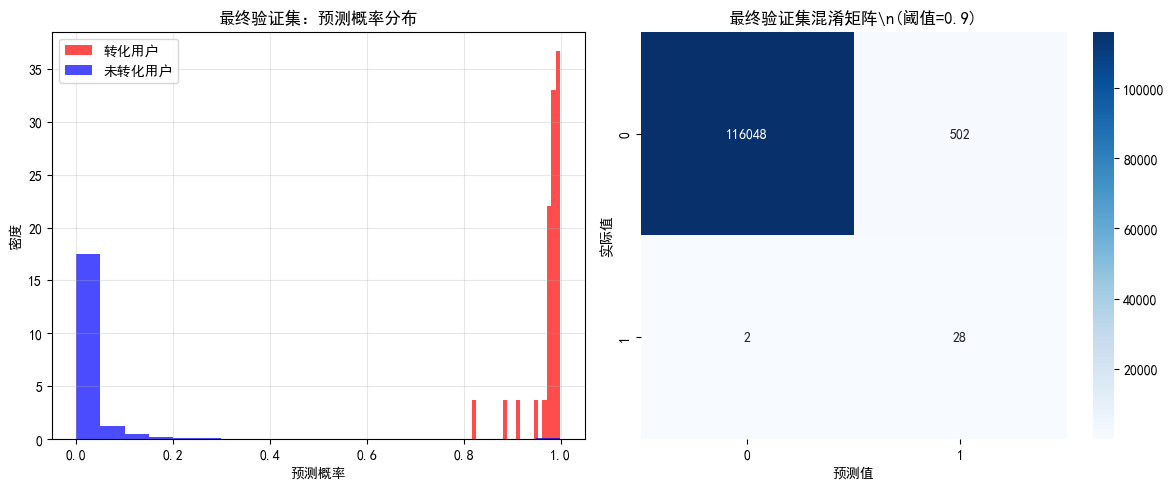

进行SHAP分析
{'explainer': <shap.explainers._linear.LinearExplainer object at 0x0000024D87896E10>, 'shap_values': array([[-6.96029789e-02, -1.47389339e+00,  4.12196703e-01, ...,
        -1.43661277e-03, -2.58725333e+00,  3.36225151e+01],
       [-1.61633584e+00, -4.21112398e-01, -4.83582724e-02, ...,
        -1.43661277e-03, -2.58725333e+00,  2.23397919e+01],
       [-3.27391790e-01, -2.52667439e+00,  6.42474190e-01, ...,
        -1.43661277e-03, -2.58725333e+00,  3.36225151e+01],
       ...,
       [ 4.45974642e-01, -4.21112398e-01,  1.81919215e-01, ...,
        -1.43661277e-03, -2.58725333e+00,  2.23397919e+01],
       [ 4.45974642e-01, -4.21112398e-01, -4.83582724e-02, ...,
        -1.43661277e-03, -2.58725333e+00,  1.10570687e+01],
       [ 1.88185832e-01, -2.52667439e+00,  4.12196703e-01, ...,
        -1.43661277e-03, -2.58725333e+00,  2.23397919e+01]],
      shape=(116580, 26)), 'feature_importance': array([6.27277747e-01, 7.92206411e-01, 9.15057709e-02, 2.61941349e-01,
       1.2062

In [25]:
# 在最终验证集上测试模型性能
# =====================================

def evaluate_on_final_validation(training_results, X_final_val, y_final_val):
    print(f"最终验证集评估（真正的未见过数据）")
    
    # 收集所有模型的预测概率
    all_predictions = []
    all_predictions_binary = []
    
    for result in training_results:
        model = result['model']
        scaler = result['scaler']
        
        # 对验证集进行标准化（保持与训练一致）
        X_val_scaled = scaler.transform(X_final_val)
        
        # 预测概率
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_pred = model.predict(X_val_scaled)
        
        all_predictions.append(y_pred_proba)
        all_predictions_binary.append(y_pred)
    
    # 集成预测（平均概率）
    ensemble_proba = np.mean(all_predictions, axis=0)
    ensemble_pred = (ensemble_proba >= 0.5).astype(int)
    # 不同阈值下的性能
    print(f"最终验证集基本信息:")
    print(f"总样本数: {len(y_final_val)}")
    print(f"正样本数: {y_final_val.sum()}")
    print(f"负样本数: {len(y_final_val) - y_final_val.sum()}")
    print(f"转化率: {y_final_val.mean():.6f}")
    
    print(f"最终验证集在不同阈值下的性能:")
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    final_threshold_results = []
    
    print("阈值    精确率   召回率    F1分数   识别转化用户数  预测正样本数")
    print("-" * 70)
    
    for threshold in thresholds:
        pred_at_threshold = (ensemble_proba >= threshold).astype(int)
        
        precision = precision_score(y_final_val, pred_at_threshold, zero_division=0)
        recall = recall_score(y_final_val, pred_at_threshold, zero_division=0)
        f1 = f1_score(y_final_val, pred_at_threshold, zero_division=0)
        identified_converted = int(recall * y_final_val.sum())
        predicted_positive = pred_at_threshold.sum()
        
        final_threshold_results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'identified_converted': identified_converted,
            'predicted_positive': predicted_positive
        })
        
        print(f"{threshold:.1f}     {precision:.4f}   {recall:.4f}    {f1:.4f}        {identified_converted}/{y_final_val.sum()}           {predicted_positive}")
    
    # 找到最佳性能
    best_recall_result = max(final_threshold_results, key=lambda x: x['recall'])
    best_f1_result = max(final_threshold_results, key=lambda x: x['f1'])
    
    print(f"最终验证集最佳性能:")
    print(f"最高召回率: {best_recall_result['recall']:.4f} (阈值: {best_recall_result['threshold']:.1f})")
    print(f"识别转化用户: {best_recall_result['identified_converted']}/{y_final_val.sum()}")
    print(f"对应精确率: {best_recall_result['precision']:.4f}")
    print(f"预测正样本数: {best_recall_result['predicted_positive']}")
    
    print(f"最高F1分数: {best_f1_result['f1']:.4f} (阈值: {best_f1_result['threshold']:.1f})")
    print(f"召回率: {best_f1_result['recall']:.4f}")
    print(f"精确率: {best_f1_result['precision']:.4f}")
    print(f"识别转化用户: {best_f1_result['identified_converted']}/{y_final_val.sum()}")
    print(f"预测正样本数: {best_f1_result['predicted_positive']}")
    
    # 模型置信度分析
    print(f"预测置信度分析:")
    positive_probas = ensemble_proba[y_final_val == 1]  # 真正转化用户的预测概率
    negative_probas = ensemble_proba[y_final_val == 0]  # 真正未转化用户的预测概率
    
    print(f"真正转化用户的平均预测概率: {positive_probas.mean():.4f}")
    print(f"真正转化用户的预测概率范围: [{positive_probas.min():.4f}, {positive_probas.max():.4f}]")
    print(f"真正未转化用户的平均预测概率: {negative_probas.mean():.4f}")
    print(f"真正未转化用户的预测概率范围: [{negative_probas.min():.4f}, {negative_probas.max():.4f}]")
    
    # 绘制概率分布
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(positive_probas, bins=20, alpha=0.7, label='转化用户', color='red', density=True)
    plt.hist(negative_probas, bins=20, alpha=0.7, label='未转化用户', color='blue', density=True)
    plt.xlabel('预测概率')
    plt.ylabel('密度')
    plt.title('最终验证集：预测概率分布')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # 混淆矩阵（使用最佳F1阈值）
    best_pred = (ensemble_proba >= best_f1_result['threshold']).astype(int)
    cm = confusion_matrix(y_final_val, best_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'最终验证集混淆矩阵\\n(阈值={best_f1_result["threshold"]:.1f})')
    plt.xlabel('预测值')
    plt.ylabel('实际值')
    
    plt.tight_layout()
    plt.show()
    
    # 5. SHAP分析
    print("进行SHAP分析")
    try:
        # 为线性模型创建SHAP explainer
        explainer = shap.LinearExplainer(result['model'], X_final_val)
        shap_values = explainer.shap_values(X_final_val)
        
        # 计算特征重要性
        feature_importance = np.abs(shap_values).mean(axis=0)
        
        shap_result = {
            'explainer': explainer,
            'shap_values': shap_values,
            'feature_importance': feature_importance,
            'feature_names': feature_names
        }
    except Exception as e:
        print(f"SHAP分析出错: {e}")
        shap_result = None
    print(shap_result)




    return {
        'ensemble_proba': ensemble_proba,
        'ensemble_pred': ensemble_pred,
        'threshold_results': final_threshold_results,
        'best_recall': best_recall_result,
        'best_f1': best_f1_result,
        'positive_probas': positive_probas,
        'negative_probas': negative_probas,
        'shap_result': shap_result
    }

# 执行最终验证集评估
print("开始最终验证集评估")
final_validation_results = evaluate_on_final_validation(
    training_results, 
    X_final_validation, 
    y_final_validation
)
ensemble_results = final_validation_results

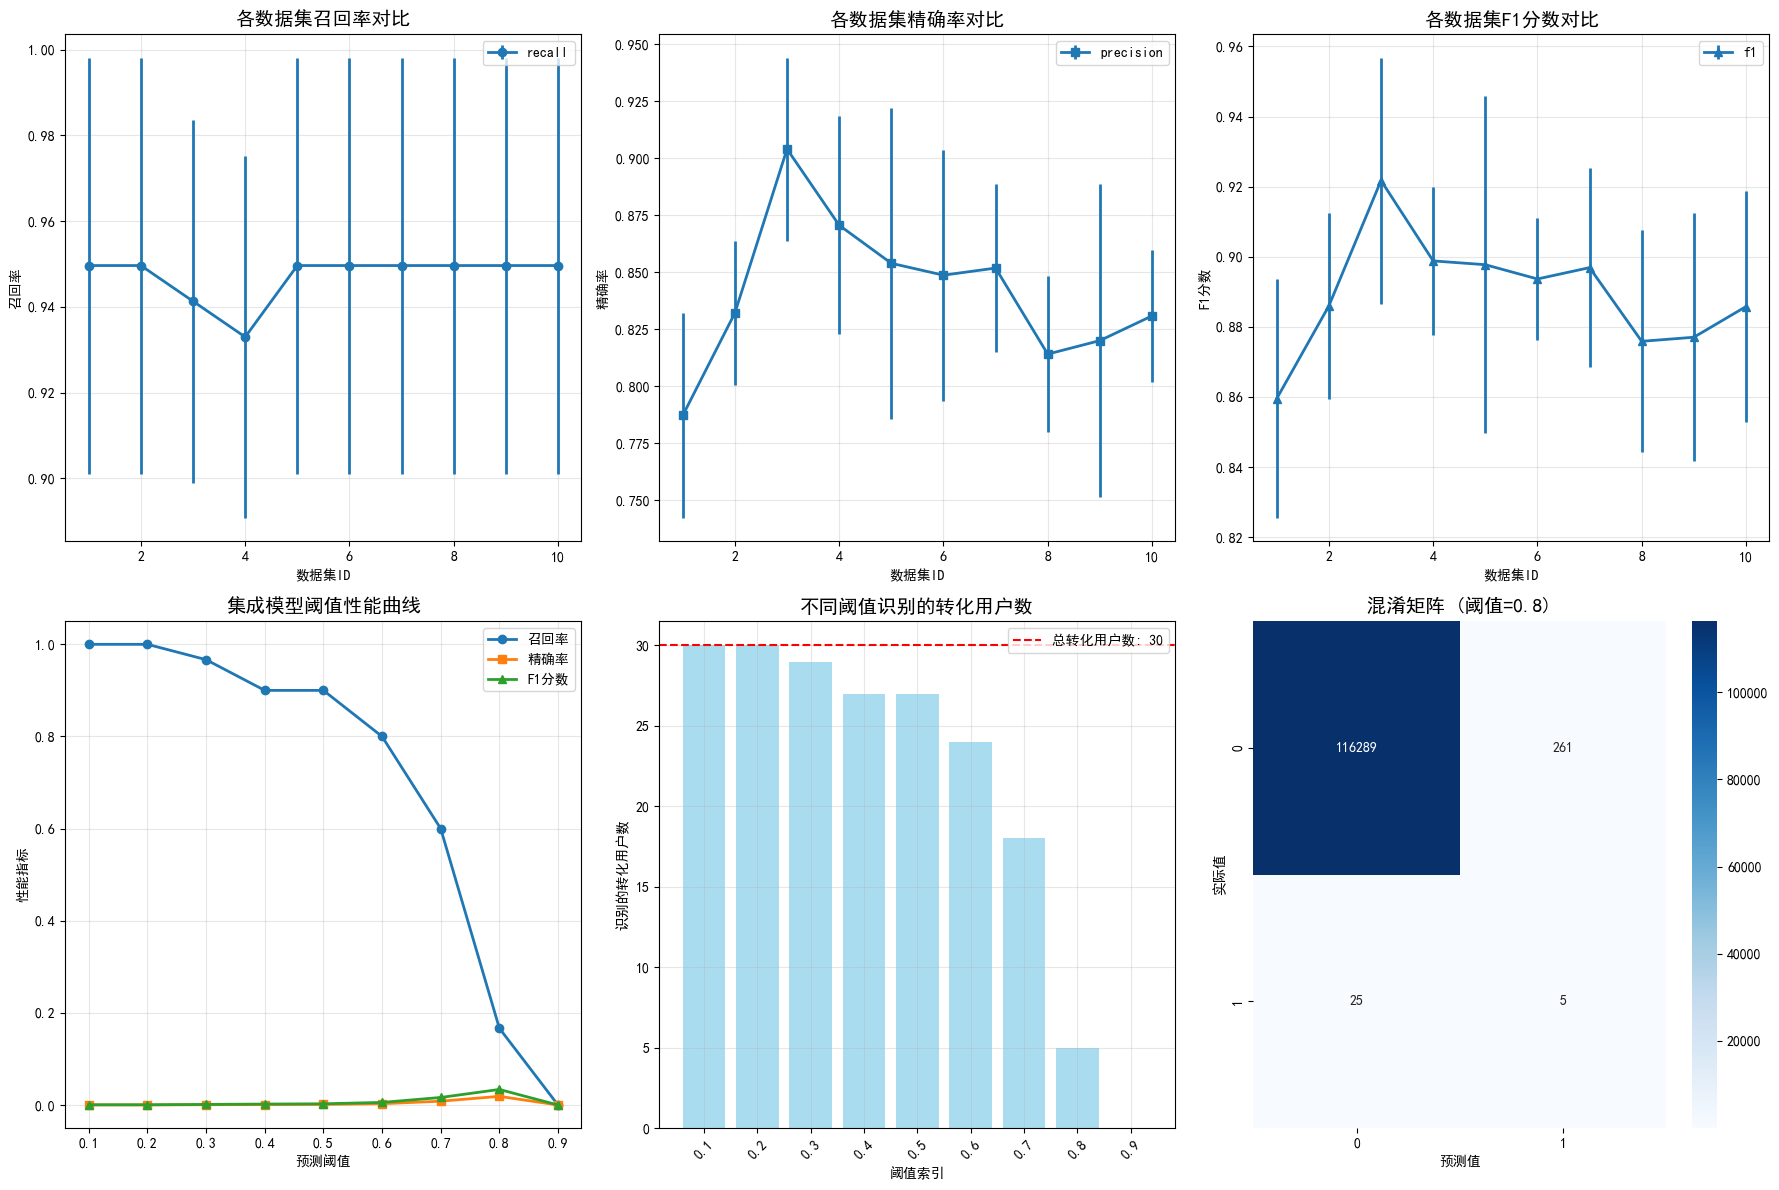

In [10]:
# 可视化分析和结果汇总
def plot_comprehensive_analysis(training_results, ensemble_results, y_full_test):
    """
    绘制综合分析图表
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    # 1. 交叉验证性能对比
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    dataset_ids = [result['dataset_id'] for result in training_results]
    
    for i, metric in enumerate(metrics):
        if i < 5:  # 只绘制前5个指标
            mean_values = [result['mean_scores'][metric] for result in training_results]
            std_values = [result['std_scores'][metric] for result in training_results]
            
            if metric == 'recall':
                axes[0, 0].errorbar(dataset_ids, mean_values, yerr=std_values, 
                                  marker='o', label=metric, linewidth=2, markersize=6)
            elif metric == 'precision':
                axes[0, 1].errorbar(dataset_ids, mean_values, yerr=std_values, 
                                  marker='s', label=metric, linewidth=2, markersize=6)
            elif metric == 'f1':
                axes[0, 2].errorbar(dataset_ids, mean_values, yerr=std_values, 
                                  marker='^', label=metric, linewidth=2, markersize=6)
    
    axes[0, 0].set_title('各数据集召回率对比', fontsize=14)
    axes[0, 0].set_xlabel('数据集ID')
    axes[0, 0].set_ylabel('召回率')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    axes[0, 1].set_title('各数据集精确率对比', fontsize=14)
    axes[0, 1].set_xlabel('数据集ID')
    axes[0, 1].set_ylabel('精确率')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    axes[0, 2].set_title('各数据集F1分数对比', fontsize=14)
    axes[0, 2].set_xlabel('数据集ID')
    axes[0, 2].set_ylabel('F1分数')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend()
    
    # 2. 阈值性能曲线
    thresholds = [result['threshold'] for result in ensemble_results['threshold_results']]
    recalls = [result['recall'] for result in ensemble_results['threshold_results']]
    precisions = [result['precision'] for result in ensemble_results['threshold_results']]
    f1s = [result['f1'] for result in ensemble_results['threshold_results']]
    
    axes[1, 0].plot(thresholds, recalls, 'o-', label='召回率', linewidth=2, markersize=6)
    axes[1, 0].plot(thresholds, precisions, 's-', label='精确率', linewidth=2, markersize=6)
    axes[1, 0].plot(thresholds, f1s, '^-', label='F1分数', linewidth=2, markersize=6)
    axes[1, 0].set_xlabel('预测阈值')
    axes[1, 0].set_ylabel('性能指标')
    axes[1, 0].set_title('集成模型阈值性能曲线', fontsize=14)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 3. 转化用户识别数量
    identified_counts = [result['identified_converted'] for result in ensemble_results['threshold_results']]
    total_converted = y_full_test.sum()
    
    axes[1, 1].bar(range(len(thresholds)), identified_counts, alpha=0.7, color='skyblue')
    axes[1, 1].axhline(y=total_converted, color='red', linestyle='--', 
                      label=f'总转化用户数: {total_converted}')
    axes[1, 1].set_xlabel('阈值索引')
    axes[1, 1].set_ylabel('识别的转化用户数')
    axes[1, 1].set_title('不同阈值识别的转化用户数', fontsize=14)
    axes[1, 1].set_xticks(range(len(thresholds)))
    axes[1, 1].set_xticklabels([f'{t:.1f}' for t in thresholds], rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 4. 混淆矩阵 (最佳F1阈值)
    best_f1_idx = np.argmax(f1s)
    best_threshold = thresholds[best_f1_idx]
    best_predictions = (ensemble_results['ensemble_proba'] >= best_threshold).astype(int)
    
    cm = confusion_matrix(y_full_test, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2])
    axes[1, 2].set_title(f'混淆矩阵 (阈值={best_threshold:.1f})', fontsize=14)
    axes[1, 2].set_xlabel('预测值')
    axes[1, 2].set_ylabel('实际值')
    
    plt.tight_layout()
    plt.show()
X_full_test = X_final_validation
y_full_test = y_final_validation

# 执行可视化和报告生成
plot_comprehensive_analysis(training_results, ensemble_results, y_full_test)


开始执行特征重要性分析
开始特征重要性分析
计算置换重要性（使用10个模型验证）...
   模型 1/10 完成
   模型 2/10 完成
   模型 3/10 完成
   模型 4/10 完成
   模型 5/10 完成
   模型 6/10 完成
   模型 7/10 完成
   模型 8/10 完成
   模型 9/10 完成
   模型 10/10 完成
特征重要性分析完成！


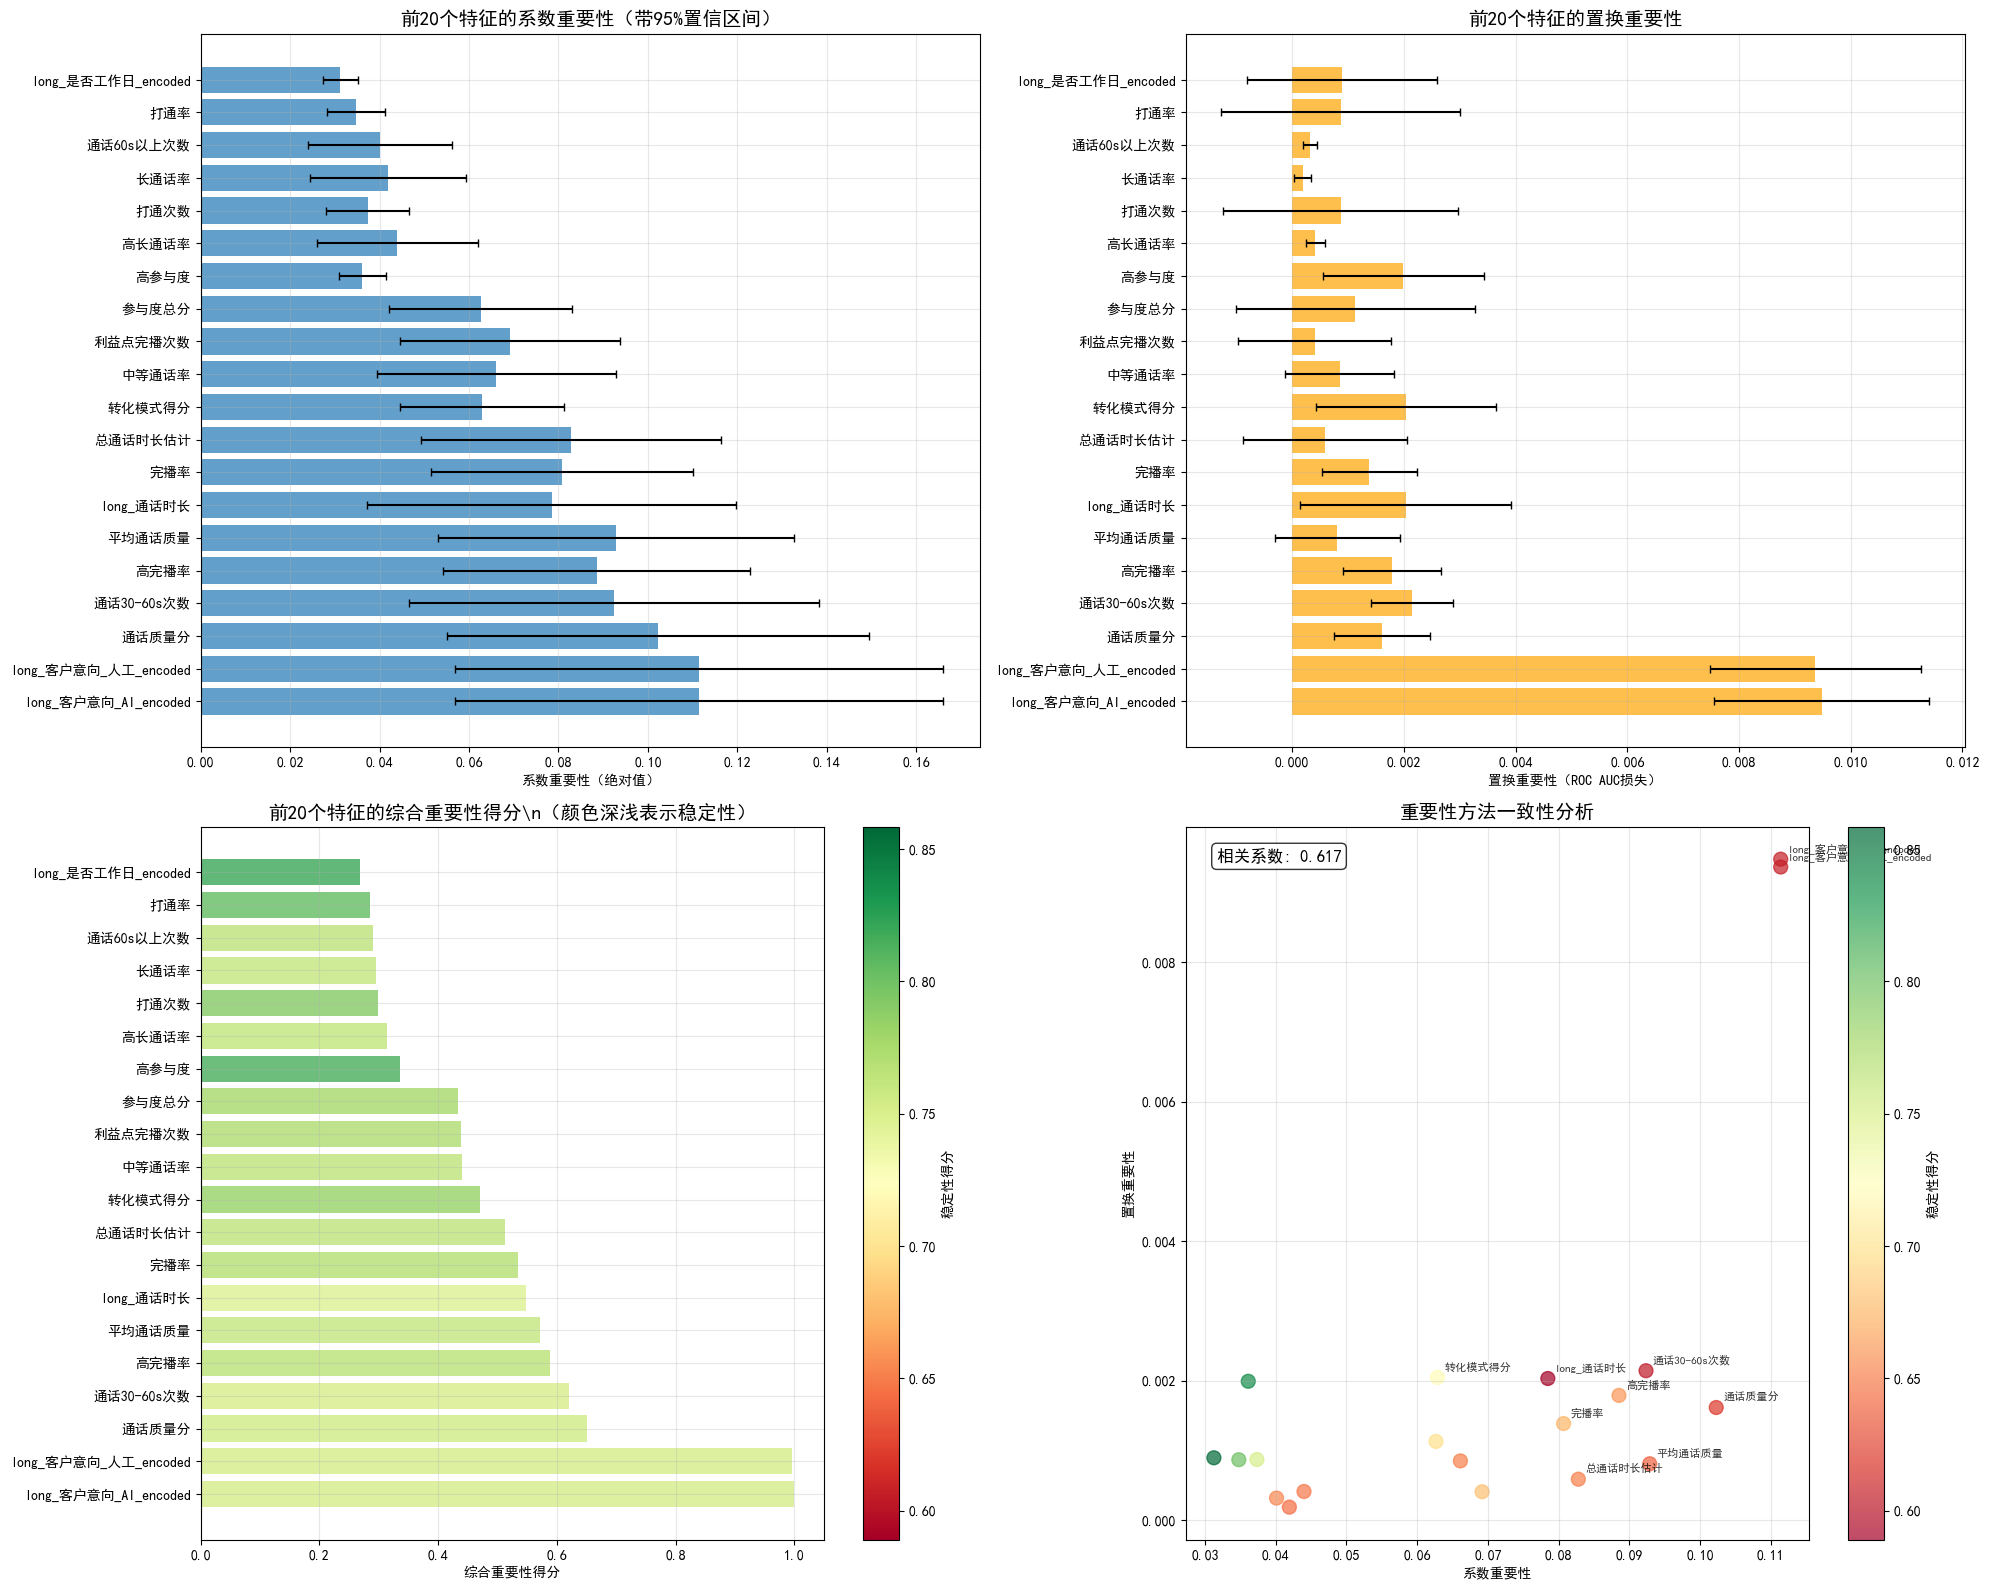

特征重要性分析报告
Top 10 最重要特征:
 1. long_客户意向_AI_encoded
综合重要性: 1.0000
系数重要性: 0.1114 (±0.0723)
置换重要性: 0.0095 (±0.0019)
稳定性得分: 0.6065
95%置信区间: [0.0569, 0.1659]

 2. long_客户意向_人工_encoded
综合重要性: 0.9957
系数重要性: 0.1114 (±0.0723)
置换重要性: 0.0094 (±0.0019)
稳定性得分: 0.6065
95%置信区间: [0.0569, 0.1659]

 3. 通话质量分
综合重要性: 0.6501
系数重要性: 0.1023 (±0.0625)
置换重要性: 0.0016 (±0.0009)
稳定性得分: 0.6206
95%置信区间: [0.0551, 0.1495]

 4. 通话30-60s次数
综合重要性: 0.6212
系数重要性: 0.0924 (±0.0608)
置换重要性: 0.0021 (±0.0007)
稳定性得分: 0.6031
95%置信区间: [0.0465, 0.1382]

 5. 高完播率
综合重要性: 0.5885
系数重要性: 0.0885 (±0.0455)
置换重要性: 0.0018 (±0.0009)
稳定性得分: 0.6606
95%置信区间: [0.0542, 0.1229]

 6. 平均通话质量
综合重要性: 0.5721
系数重要性: 0.0929 (±0.0527)
置换重要性: 0.0008 (±0.0011)
稳定性得分: 0.6379
95%置信区间: [0.0531, 0.1327]

 7. long_通话时长
综合重要性: 0.5479
系数重要性: 0.0785 (±0.0548)
置换重要性: 0.0020 (±0.0019)
稳定性得分: 0.5891
95%置信区间: [0.0372, 0.1198]

 8. 完播率
综合重要性: 0.5339
系数重要性: 0.0807 (±0.0388)
置换重要性: 0.0014 (±0.0008)
稳定性得分: 0.6753
95%置信区间: [0.0514, 0.1100]

 9. 总通话时长估计
综合重要性: 0.5134
系数重要性: 0.

In [11]:
# 特征重要性分析（包含置信度计算）
# 基于逻辑回归的系数，shap值在后面的cell

def analyze_feature_importance_with_confidence(training_results, X_test, y_test, feature_names):
    """
    分析特征重要性并计算置信度
    
    参数:
    - training_results: 训练结果列表
    - X_test: 测试特征
    - y_test: 测试标签  
    - feature_names: 特征名称列表
    
    返回:
    - 特征重要性分析结果
    """
    
    print("开始特征重要性分析")
    # 1. 收集所有模型的系数重要性
    coefficients_matrix = []
    
    for result in training_results:
        model = result['model']
        # 获取逻辑回归系数（绝对值表示重要性）
        coeffs = np.abs(model.coef_[0])
        coefficients_matrix.append(coeffs)
    
    coefficients_matrix = np.array(coefficients_matrix)
    
    # 2. 计算系数重要性统计
    coef_importance = {
        'feature': feature_names,
        'mean_importance': np.mean(coefficients_matrix, axis=0),
        'std_importance': np.std(coefficients_matrix, axis=0),
        'min_importance': np.min(coefficients_matrix, axis=0),
        'max_importance': np.max(coefficients_matrix, axis=0)
    }
    
    # 计算置信区间 (95%)
    confidence_intervals = []
    for i in range(len(feature_names)):
        feature_coeffs = coefficients_matrix[:, i]
        # 计算95%置信区间
        ci_lower, ci_upper = stats.t.interval(
            confidence=0.95,
            df=len(feature_coeffs)-1,
            loc=np.mean(feature_coeffs),
            scale=stats.sem(feature_coeffs)
        )
        confidence_intervals.append((ci_lower, ci_upper))
    
    coef_importance['confidence_interval'] = confidence_intervals
    
    # 3. 计算变异系数（稳定性指标）
    cv_scores = coef_importance['std_importance'] / (coef_importance['mean_importance'] + 1e-10)
    coef_importance['coefficient_variation'] = cv_scores
    
    # 4. 使用置换重要性验证
    print("计算置换重要性（使用10个模型验证）...")
    
    permutation_scores = []
    for i, result in enumerate(training_results[:10]):  # 只用10个模型
        model = result['model']
        scaler = result['scaler']
        
        # 标准化测试数据
        X_test_scaled = scaler.transform(X_test)
        
        # 计算置换重要性
        perm_importance = permutation_importance(
            model, X_test_scaled, y_test,
            scoring='roc_auc',
            n_repeats=5,
            random_state=42
        )
        
        permutation_scores.append(perm_importance.importances_mean)
        print(f"   模型 {i+1}/10 完成")
    
    # 计算置换重要性统计
    permutation_matrix = np.array(permutation_scores)
    perm_importance = {
        'mean_importance': np.mean(permutation_matrix, axis=0),
        'std_importance': np.std(permutation_matrix, axis=0)
    }
    
    # 5. 创建综合重要性数据框
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coef_importance': coef_importance['mean_importance'],
        'coef_std': coef_importance['std_importance'],
        'coef_cv': coef_importance['coefficient_variation'],
        'confidence_lower': [ci[0] for ci in coef_importance['confidence_interval']],
        'confidence_upper': [ci[1] for ci in coef_importance['confidence_interval']],
        'perm_importance': perm_importance['mean_importance'],
        'perm_std': perm_importance['std_importance']
    })
    
    # 计算综合重要性得分（系数重要性 + 置换重要性的标准化组合）
    coef_norm = (importance_df['coef_importance'] - importance_df['coef_importance'].min()) / \
                (importance_df['coef_importance'].max() - importance_df['coef_importance'].min() + 1e-10)
    perm_norm = (importance_df['perm_importance'] - importance_df['perm_importance'].min()) / \
                (importance_df['perm_importance'].max() - importance_df['perm_importance'].min() + 1e-10)
    
    importance_df['combined_importance'] = (coef_norm + perm_norm) / 2
    
    # 计算稳定性得分（变异系数越小，稳定性越高）
    importance_df['stability_score'] = 1 / (1 + importance_df['coef_cv'])
    
    # 按综合重要性排序
    importance_df = importance_df.sort_values('combined_importance', ascending=False)
    
    print("特征重要性分析完成！")
    
    return importance_df

def plot_feature_importance_analysis(importance_df, top_n=20):
    """
    可视化特征重要性分析结果
    """
    
    # 取前N个最重要的特征
    top_features = importance_df.head(top_n)
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. 系数重要性排序（带置信区间）
    ax1 = axes[0, 0]
    y_pos = np.arange(len(top_features))
    
    # 绘制误差条
    ax1.barh(y_pos, top_features['coef_importance'], 
             xerr=[top_features['coef_importance'] - top_features['confidence_lower'],
                   top_features['confidence_upper'] - top_features['coef_importance']],
             alpha=0.7, capsize=3)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_features['feature'], fontsize=10)
    ax1.set_xlabel('系数重要性（绝对值）')
    ax1.set_title(f'前{top_n}个特征的系数重要性（带95%置信区间）', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. 置换重要性
    ax2 = axes[0, 1]
    y_pos = np.arange(len(top_features))
    
    bars = ax2.barh(y_pos, top_features['perm_importance'], 
                    xerr=top_features['perm_std'],
                    alpha=0.7, capsize=3, color='orange')
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_features['feature'], fontsize=10)
    ax2.set_xlabel('置换重要性（ROC AUC损失）')
    ax2.set_title(f'前{top_n}个特征的置换重要性', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. 综合重要性得分
    ax3 = axes[1, 0]
    
    # 使用颜色表示稳定性
    colors = plt.cm.RdYlGn(top_features['stability_score'])
    bars = ax3.barh(y_pos, top_features['combined_importance'], color=colors, alpha=0.8)
    
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(top_features['feature'], fontsize=10)
    ax3.set_xlabel('综合重要性得分')
    ax3.set_title(f'前{top_n}个特征的综合重要性得分\\n（颜色深浅表示稳定性）', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, 
                              norm=plt.Normalize(vmin=top_features['stability_score'].min(), 
                                               vmax=top_features['stability_score'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3)
    cbar.set_label('稳定性得分')
    
    # 4. 重要性相关性分析
    ax4 = axes[1, 1]
    
    # 散点图：系数重要性 vs 置换重要性
    scatter = ax4.scatter(top_features['coef_importance'], 
                         top_features['perm_importance'],
                         c=top_features['stability_score'],
                         s=100, alpha=0.7, cmap='RdYlGn')
    
    # 添加特征名称标注（仅显示前10个）
    for i, (idx, row) in enumerate(top_features.head(10).iterrows()):
        ax4.annotate(row['feature'], 
                    (row['coef_importance'], row['perm_importance']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)
    
    ax4.set_xlabel('系数重要性')
    ax4.set_ylabel('置换重要性')
    ax4.set_title('重要性方法一致性分析', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 计算相关系数
    correlation = np.corrcoef(top_features['coef_importance'], 
                             top_features['perm_importance'])[0, 1]
    ax4.text(0.05, 0.95, f'相关系数: {correlation:.3f}', 
             transform=ax4.transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.colorbar(scatter, ax=ax4, label='稳定性得分')
    
    plt.tight_layout()
    plt.show()

def generate_feature_importance_report(importance_df):
    """
    生成特征重要性分析报告
    """
    print("特征重要性分析报告")
    
    # 1. Top 10 最重要特征
    print("Top 10 最重要特征:")

    
    top_10 = importance_df.head(10)
    for i, (idx, row) in enumerate(top_10.iterrows(), 1):
        print(f"{i:2d}. {row['feature']}")
        print(f"综合重要性: {row['combined_importance']:.4f}")
        print(f"系数重要性: {row['coef_importance']:.4f} (±{row['coef_std']:.4f})")
        print(f"置换重要性: {row['perm_importance']:.4f} (±{row['perm_std']:.4f})")
        print(f"稳定性得分: {row['stability_score']:.4f}")
        print(f"95%置信区间: [{row['confidence_lower']:.4f}, {row['confidence_upper']:.4f}]")
        print()
    
    # 2. 特征分类分析
    print("特征分类分析:")
    # 根据特征名称分类
    feature_categories = {
        '通话相关': [],
        '转化模式': [],
        '渠道相关': [],
        '时间相关': [],
        '其他': []
    }
    
    for _, row in importance_df.iterrows():
        feature = row['feature']
        if any(keyword in feature for keyword in ['通话', '打通', '完播', '拨打']):
            feature_categories['通话相关'].append((feature, row['combined_importance']))
        elif any(keyword in feature for keyword in ['转化', '模式', '高']):
            feature_categories['转化模式'].append((feature, row['combined_importance']))
        elif any(keyword in feature for keyword in ['渠道', '白名单']):
            feature_categories['渠道相关'].append((feature, row['combined_importance']))
        elif any(keyword in feature for keyword in ['时段', '工作日', '周']):
            feature_categories['时间相关'].append((feature, row['combined_importance']))
        else:
            feature_categories['其他'].append((feature, row['combined_importance']))
    
    for category, features in feature_categories.items():
        if features:
            avg_importance = np.mean([imp for _, imp in features])
            print(f"{category}: {len(features)}个特征, 平均重要性: {avg_importance:.4f}")
            # 显示该类别最重要的特征
            top_feature = max(features, key=lambda x: x[1])
            print(f"   最重要: {top_feature[0]} ({top_feature[1]:.4f})")
    
    # 4. 置信度分析
    print("置信度分析:")
    print("-" * 40)
    
    # 计算置信区间宽度
    confidence_width = importance_df['confidence_upper'] - importance_df['confidence_lower']
    
    narrow_ci = importance_df[confidence_width < confidence_width.quantile(0.25)]
    wide_ci = importance_df[confidence_width > confidence_width.quantile(0.75)]
    
    print(f"高置信度特征 (窄置信区间): {len(narrow_ci)}个")
    print(f"低置信度特征 (宽置信区间): {len(wide_ci)}个")
    print(f"平均置信区间宽度: {confidence_width.mean():.4f}")

    
    return importance_df

# 执行特征重要性分析
print("开始执行特征重要性分析")
importance_results = analyze_feature_importance_with_confidence(
    training_results, 
    X_full_test, 
    y_full_test, 
    feature_names
)

# 可视化分析结果
plot_feature_importance_analysis(importance_results, top_n=20)

# 生成详细报告
final_importance_df = generate_feature_importance_report(importance_results)


In [12]:
# 保存特征重要性结果

import os
from datetime import datetime

# 创建保存目录
save_dir = "特征重要性分析结果"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 生成时间戳
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 保存详细的重要性数据
importance_file = f"{save_dir}/特征重要性分析_{timestamp}.xlsx"
with pd.ExcelWriter(importance_file, engine='openpyxl') as writer:
    # 保存完整的重要性分析结果
    final_importance_df.to_excel(writer, sheet_name='特征重要性排序', index=False)
    
    # 创建Top 10汇总
    top_10_summary = final_importance_df.head(10)[['feature', 'combined_importance', 
                                                    'coef_importance', 'perm_importance', 
                                                    'stability_score']].copy()
    top_10_summary.columns = ['特征名称', '综合重要性', '系数重要性', '置换重要性', '稳定性得分']
    top_10_summary.to_excel(writer, sheet_name='Top10特征汇总', index=False)
    
    # 创建分类汇总
    feature_categories_summary = []
    feature_categories = {
        '通话相关': [],
        '转化模式': [],
        '渠道相关': [],
        '时间相关': [],
        '其他': []
    }
    
    for _, row in final_importance_df.iterrows():
        feature = row['feature']
        if any(keyword in feature for keyword in ['通话', '打通', '完播', '拨打']):
            feature_categories['通话相关'].append(row['combined_importance'])
        elif any(keyword in feature for keyword in ['转化', '模式', '高']):
            feature_categories['转化模式'].append(row['combined_importance'])
        elif any(keyword in feature for keyword in ['渠道', '白名单']):
            feature_categories['渠道相关'].append(row['combined_importance'])
        elif any(keyword in feature for keyword in ['时段', '工作日', '周']):
            feature_categories['时间相关'].append(row['combined_importance'])
        else:
            feature_categories['其他'].append(row['combined_importance'])
    
    for category, importances in feature_categories.items():
        if importances:
            feature_categories_summary.append({
                '特征类别': category,
                '特征数量': len(importances),
                '平均重要性': np.mean(importances),
                '最高重要性': np.max(importances),
                '最低重要性': np.min(importances)
            })
    
    category_df = pd.DataFrame(feature_categories_summary)
    category_df.to_excel(writer, sheet_name='特征分类汇总', index=False)

print(f"特征重要性分析结果已保存到: {importance_file}")

# 创建简化的重要性字典（供其他模块使用）
importance_dict = dict(zip(final_importance_df['feature'], 
                          final_importance_df['combined_importance']))

# 显示保存的文件信息
print(f"保存的文件包含以下内容:")
print(f"特征重要性排序: 包含{len(final_importance_df)}个特征的完整分析")
print(f"Top10特征汇总: 最重要的10个特征详情")  
print(f"特征分类汇总: 按业务类别归类的重要性统计")

# 快速查看Top 5特征及其置信度
print(f"Top 5 特征重要性快速预览:")
for i, (_, row) in enumerate(final_importance_df.head(5).iterrows(), 1):
    ci_width = row['confidence_upper'] - row['confidence_lower']
    print(f"{i}. {row['feature']}")
    print(f"重要性: {row['combined_importance']:.4f}")
    print(f"置信区间: [{row['confidence_lower']:.4f}, {row['confidence_upper']:.4f}] (宽度: {ci_width:.4f})")
    print(f"稳定性: {row['stability_score']:.4f}")
    print()

print("特征重要性分析完成！可以在其他分析中使用 `importance_dict` 变量")


特征重要性分析结果已保存到: 特征重要性分析结果/特征重要性分析_20250811_152054.xlsx
保存的文件包含以下内容:
特征重要性排序: 包含26个特征的完整分析
Top10特征汇总: 最重要的10个特征详情
特征分类汇总: 按业务类别归类的重要性统计
Top 5 特征重要性快速预览:
1. long_客户意向_AI_encoded
重要性: 1.0000
置信区间: [0.0569, 0.1659] (宽度: 0.1090)
稳定性: 0.6065

2. long_客户意向_人工_encoded
重要性: 0.9957
置信区间: [0.0569, 0.1659] (宽度: 0.1090)
稳定性: 0.6065

3. 通话质量分
重要性: 0.6501
置信区间: [0.0551, 0.1495] (宽度: 0.0943)
稳定性: 0.6206

4. 通话30-60s次数
重要性: 0.6212
置信区间: [0.0465, 0.1382] (宽度: 0.0917)
稳定性: 0.6031

5. 高完播率
重要性: 0.5885
置信区间: [0.0542, 0.1229] (宽度: 0.0686)
稳定性: 0.6606

特征重要性分析完成！可以在其他分析中使用 `importance_dict` 变量


In [13]:
shap_feature_importanc = final_validation_results['shap_result']['feature_importance'] 
shap_feature_importanc
# 1. 提取 shap_values 数组，计算绝对值并按特征求均值
shap_importance = final_validation_results['shap_result']['feature_importance']   # 长度为 n_features
shap_features = final_validation_results['shap_result']['feature_names']  
# 2. 构建新的 DataFrame 或合并到已有 DataFrame
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': shap_feature_importanc
})
shap_df
# importance_df，做 merge：
final_importance_df = final_importance_df.merge(shap_df, on='feature', how='left')
final_importance_df

,feature,coef_importance,coef_std,coef_cv,confidence_lower,confidence_upper,perm_importance,perm_std,combined_importance,stability_score,shap_importance
0,long_客户意向_AI_encoded,0.111425,0.072295,0.648828,0.056910,0.165939,0.009478,0.001932,1.000000,0.606491,0.194122
1,long_客户意向_人工_encoded,0.111425,0.072295,0.648828,0.056910,0.165939,0.009366,0.001892,0.995651,0.606491,0.194116
2,通话质量分,0.102304,0.062542,0.611338,0.055144,0.149465,0.001614,0.000858,0.650114,0.620602,0.015363
3,通话30-60s次数,0.092375,0.060786,0.658033,0.046539,0.138210,0.002142,0.000738,0.621198,0.603124,0.009900
4,高完播率,0.088546,0.045497,0.513820,0.054239,0.122853,0.001788,0.000876,0.588454,0.660581,0.021416
5,平均通话质量,0.092897,0.052723,0.567545,0.053141,0.132653,0.000807,0.001118,0.572110,0.637940,0.510507
6,long_通话时长,0.078487,0.054752,0.697594,0.037201,0.119773,0.002030,0.001896,0.547851,0.589069,0.548626
7,完播率,0.080712,0.038816,0.480915,0.051443,0.109981,0.001384,0.000848,0.533890,0.675258,0.017077
8,总通话时长估计,0.082802,0.044397,0.536190,0.049324,0.116280,0.000586,0.001461,0.513357,0.650961,0.733795
9,转化模式得分,0.062881,0.024345,0.387152,0.044524,0.081238,0.002045,0.001610,0.470860,0.720902,0.056579


In [14]:
# 实际置信区间分析工具
# SHAP

def analyze_confidence_intervals(importance_df):
    """
    分析实际数据的置信区间并提供建议
    """
    
    print("数据置信区间分析")
    # 计算置信区间宽度
    importance_df['ci_width'] = importance_df['confidence_upper'] - importance_df['confidence_lower']
    #相对区间宽度
    importance_df['ci_width']= importance_df['ci_width'] / (importance_df['combined_importance'].abs() + 1e-8)
    print(f"最可信的Top 10特征 (置信区间最窄):") 
    # 按置信区间宽度排序，找出最可信的特征
    most_reliable = importance_df.nsmallest(10, 'ci_width')
    
    for i, (_, row) in enumerate(most_reliable.iterrows(), 1):
        print(f"{i}. {row['feature']}")
        print(f"重要性: {row['combined_importance']:.4f}")
        print(f"置信区间: [{row['confidence_lower']:.4f}, {row['confidence_upper']:.4f}]")
        print(f"区间宽度: {row['ci_width']:.4f}")
        print()
    
    return importance_df

def create_confidence_summary_table(importance_df):
    """
    创建置信度汇总表
    """
    
    print(f"置信度汇总表")
    
    # 选择关键列并重命名
    summary_cols = ['feature', 'combined_importance', 'confidence_lower', 
                   'confidence_upper', 'ci_width', 'stability_score']
    
    summary_df = importance_df[summary_cols].head(30).copy()
    
    # 重命名列
    summary_df.columns = ['特征名称', '综合重要性', '置信下限', '置信上限', 
                         '区间宽度', '稳定性得分']
    # 格式化数值
    for col in ['综合重要性', '置信下限', '置信上限', '区间宽度', '稳定性得分']:
        summary_df[col] = summary_df[col].round(4)
    
    print(summary_df.to_string(index=False))
    
    return summary_df

# 检查是否有importance结果可以分析
try:
    if 'final_importance_df' in locals():
        print("分析您的实际特征重要性置信区间...")
        
        # 分析置信区间
        analyzed_df = analyze_confidence_intervals(final_importance_df)
        
        # 创建汇总表
        summary_table = create_confidence_summary_table(analyzed_df)
        
    else:
        print(" 请先运行特征重要性分析代码以获得 final_importance_df")
        
except Exception as e:
    print(f"分析过程中出错: {e}")
    print("请确保已经运行了特征重要性分析的代码")


分析您的实际特征重要性置信区间...
数据置信区间分析
最可信的Top 10特征 (置信区间最窄):
1. long_是否工作日_encoded
重要性: 0.2690
置信区间: [0.0274, 0.0351]
区间宽度: 0.0289

2. 高参与度
重要性: 0.3357
置信区间: [0.0309, 0.0413]
区间宽度: 0.0311

3. long_周几_encoded
重要性: 0.1893
置信区间: [0.0124, 0.0200]
区间宽度: 0.0403

4. 打通率
重要性: 0.2855
置信区间: [0.0283, 0.0413]
区间宽度: 0.0457

5. 打通次数
重要性: 0.2983
置信区间: [0.0280, 0.0467]
区间宽度: 0.0625

6. 转化模式得分
重要性: 0.4709
置信区间: [0.0445, 0.0812]
区间宽度: 0.0780

7. 参与度总分
重要性: 0.4343
置信区间: [0.0422, 0.0831]
区间宽度: 0.0942

8. long_呼叫时段_encoded
重要性: 0.1658
置信区间: [0.0076, 0.0241]
区间宽度: 0.1000

9. long_客户意向_AI_encoded
重要性: 1.0000
置信区间: [0.0569, 0.1659]
区间宽度: 0.1090

10. long_客户意向_人工_encoded
重要性: 0.9957
置信区间: [0.0569, 0.1659]
区间宽度: 0.1095

置信度汇总表
                特征名称  综合重要性    置信下限   置信上限         区间宽度  稳定性得分
long_客户意向_AI_encoded 1.0000  0.0569 0.1659       0.1090 0.6065
long_客户意向_人工_encoded 0.9957  0.0569 0.1659       0.1095 0.6065
               通话质量分 0.6501  0.0551 0.1495       0.1451 0.6206
          通话30-60s次数 0.6212  0.0465 0.1382     

 开始绘制最可信的Top 10特征图表...
绘制最可信的Top 10特征...


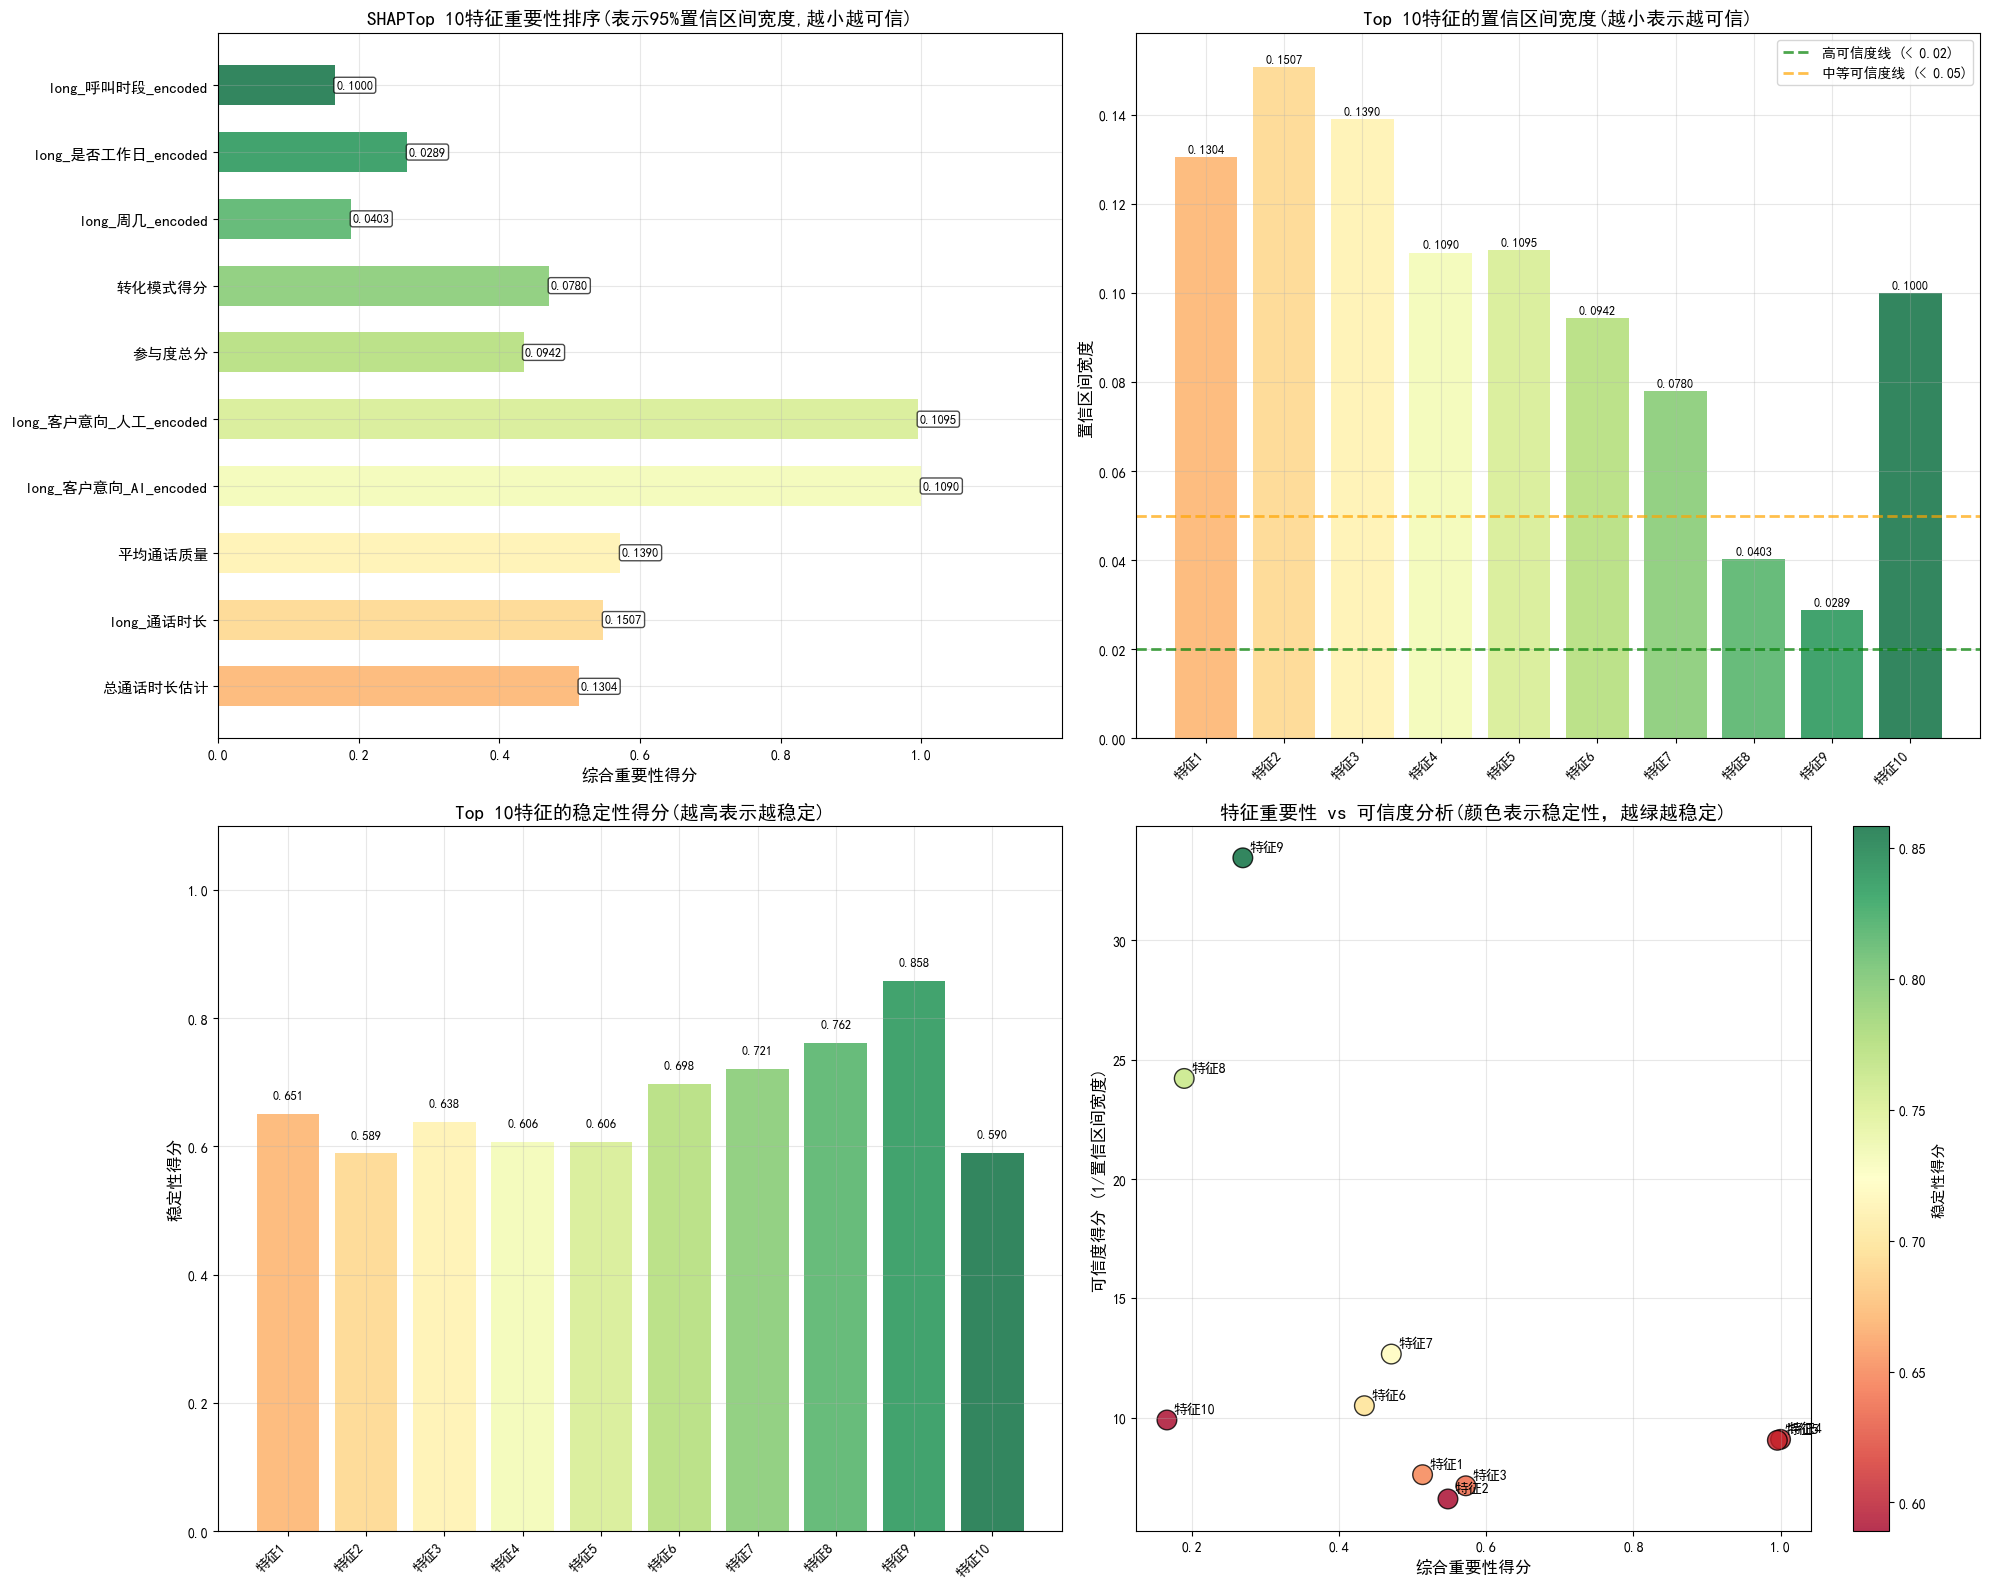

特征编号对照表:
特征1: 总通话时长估计
特征2: long_通话时长
特征3: 平均通话质量
特征4: long_客户意向_AI_encoded
特征5: long_客户意向_人工_encoded
特征6: 参与度总分
特征7: 转化模式得分
特征8: long_周几_encoded
特征9: long_是否工作日_encoded
特征10: long_呼叫时段_encoded
最可信Top 10特征统计:
平均重要性得分: 0.5158
平均置信区间宽度: 0.0980
平均稳定性得分: 0.6720
高可信度特征数量: 0/10
可信度优秀率: 0.0%
图表绘制完成！


In [15]:
# 绘制最可信的Top 10特征图表
# ============================

def plot_most_reliable_top10_features(importance_df):
    """
    绘制最可信的Top 10特征的详细图表
    """
    
    print("绘制最可信的Top 10特征...")
    
    # 计算置信区间宽度
    if 'ci_width' not in importance_df.columns:
        importance_df['ci_width'] = importance_df['confidence_upper'] - importance_df['confidence_lower']
        importance_df['ci_width']=  (importance_df['confidence_upper'] - importance_df['confidence_lower'])/ (importance_df['combined_importance'].abs() + 1e-8)
    # 按shap重要性排序，选择最可信的Top 10
    importance_df['shap_importance']
    most_reliable_top10 = importance_df.nlargest(10, 'shap_importance').copy()
    
    # 创建大图表
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 设置颜色方案
    colors = plt.cm.RdYlGn(np.linspace(0.3, 1.0, 10))  # 绿色系表示可信度高
    
    # 1. 特征重要性排序（带置信区间）
    ax1 = axes[0, 0]
    y_pos = np.arange(len(most_reliable_top10))
    
    # 绘制条形图
    bars = ax1.barh(y_pos, most_reliable_top10['combined_importance'], 
                   color=colors, alpha=0.8, height=0.6)
    
    # 绘制置信区间
    for i, (_, row) in enumerate(most_reliable_top10.iterrows()):
        # 标注置信区间宽度
        ax1.text(row['combined_importance'] + 0.002, i, 
                f'{row["ci_width"]:.4f}', 
                verticalalignment='center', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(most_reliable_top10['feature'], fontsize=11)
    ax1.set_xlabel('综合重要性得分', fontsize=12, fontweight='bold')
    ax1.set_title('SHAPTop 10特征重要性排序(表示95%置信区间宽度,越小越可信)', 
                 fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(most_reliable_top10['combined_importance']) * 1.2)
    
    # 2. 置信区间宽度比较
    ax2 = axes[0, 1]
    
    bars2 = ax2.bar(range(len(most_reliable_top10)), most_reliable_top10['ci_width'], 
                   color=colors, alpha=0.8)
    
    ax2.set_xticks(range(len(most_reliable_top10)))
    ax2.set_xticklabels([f'特征{i+1}' for i in range(len(most_reliable_top10))], 
                       rotation=45, ha='right')
    ax2.set_ylabel('置信区间宽度', fontsize=12, fontweight='bold')
    ax2.set_title('Top 10特征的置信区间宽度(越小表示越可信)', 
                 fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 在每个柱子上标注数值
    for i, (bar, width) in enumerate(zip(bars2, most_reliable_top10['ci_width'])):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0005, 
                f'{width:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 添加分界线（可信度标准）
    ax2.axhline(y=0.02, color='green', linestyle='--', alpha=0.7, linewidth=2,
               label='高可信度线 (< 0.02)')
    ax2.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, linewidth=2,
               label='中等可信度线 (< 0.05)')
    ax2.legend()
    
    # 3. 稳定性得分对比
    ax3 = axes[1, 0]
    
    bars3 = ax3.bar(range(len(most_reliable_top10)), most_reliable_top10['stability_score'], 
                   color=colors, alpha=0.8)
    
    ax3.set_xticks(range(len(most_reliable_top10)))
    ax3.set_xticklabels([f'特征{i+1}' for i in range(len(most_reliable_top10))], 
                       rotation=45, ha='right')
    ax3.set_ylabel('稳定性得分', fontsize=12, fontweight='bold')
    ax3.set_title('Top 10特征的稳定性得分(越高表示越稳定)', 
                 fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.1)
    
    # 在每个柱子上标注数值
    for i, (bar, score) in enumerate(zip(bars3, most_reliable_top10['stability_score'])):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{score:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 4. 综合评估雷达图风格的散点图
    ax4 = axes[1, 1]
    
    # 散点图：重要性 vs 可信度（用置信区间宽度的倒数表示）
    reliability_score = 1 / (most_reliable_top10['ci_width'] + 0.001)  # 避免除零
    
    scatter = ax4.scatter(most_reliable_top10['combined_importance'], 
                         reliability_score,
                         c=most_reliable_top10['stability_score'],
                         s=200, alpha=0.8, cmap='RdYlGn', edgecolors='black')
    
    # 添加特征名称标注
    for i, (_, row) in enumerate(most_reliable_top10.iterrows()):
        ax4.annotate(f'特征{i+1}', 
                    (row['combined_importance'], reliability_score.iloc[i]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold')
    
    ax4.set_xlabel('综合重要性得分', fontsize=12, fontweight='bold')
    ax4.set_ylabel('可信度得分 (1/置信区间宽度)', fontsize=12, fontweight='bold')
    ax4.set_title('特征重要性 vs 可信度分析(颜色表示稳定性，越绿越稳定)', 
                 fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('稳定性得分', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # 输出特征对照表
    print("特征编号对照表:")
    for i, (_, row) in enumerate(most_reliable_top10.iterrows(), 1):
        print(f"特征{i}: {row['feature']}")
    
    print("最可信Top 10特征统计:")
    print(f"平均重要性得分: {most_reliable_top10['combined_importance'].mean():.4f}")
    print(f"平均置信区间宽度: {most_reliable_top10['ci_width'].mean():.4f}")
    print(f"平均稳定性得分: {most_reliable_top10['stability_score'].mean():.4f}")
    
    high_confidence_count = len(most_reliable_top10[most_reliable_top10['ci_width'] <= 0.02])
    print(f"高可信度特征数量: {high_confidence_count}/10")
    print(f"可信度优秀率: {high_confidence_count/10*100:.1f}%")
    
    return most_reliable_top10

# 执行绘图函数
try:
    if 'final_importance_df' in locals():
        print(" 开始绘制最可信的Top 10特征图表...")
        
        # 绘制图表
        top10_reliable = plot_most_reliable_top10_features(final_importance_df)
        
        print("图表绘制完成！")
        
    else:
        print(" 请先运行特征重要性分析代码以获得 final_importance_df")
        print(" 运行顺序：特征重要性分析 → 置信区间分析 → 绘制图表")
        
except Exception as e:
    print(f"绘图过程中出错: {e}")
    print(" 请确保已经运行了特征重要性分析的代码")


In [16]:
# 这一部分是保存模型
# 定义集成预测器类 (移到模块级别以支持pickle序列化)
# =========================================================

class EnsemblePredictor:
    """
    集成预测器类 - 用于加载和使用训练好的多个逻辑回归模型
    """
    def __init__(self, models, feature_names, threshold_strategies):
        self.models = models  # 包含model和scaler的列表
        self.feature_names = feature_names
        self.threshold_strategies = threshold_strategies
        self.n_models = len(models)
        
    def predict_proba(self, X):
        """预测概率（集成平均）"""
        if isinstance(X, pd.DataFrame):
            X = X[self.feature_names].values
        
        all_probas = []
        for model_info in self.models:
            X_scaled = model_info['scaler'].transform(X)
            proba = model_info['model'].predict_proba(X_scaled)[:, 1]
            all_probas.append(proba)
        
        return np.mean(all_probas, axis=0)
    
    def predict(self, X, threshold=0.5):
        """预测类别"""
        probas = self.predict_proba(X)
        return (probas >= threshold).astype(int)
    
    def predict_with_strategy(self, X, strategy_name):
        """使用特定策略预测"""
        probas = self.predict_proba(X)
        
        strategy_thresholds = {
            '最高召回率策略': self.threshold_strategies[0][1]['threshold'],
            '最高F1策略': self.threshold_strategies[1][1]['threshold'],
            '最高精确率策略': self.threshold_strategies[2][1]['threshold'],
            '业务平衡策略': self.threshold_strategies[3][1]['threshold']
        }
        
        threshold = strategy_thresholds.get(strategy_name, 0.5)
        return (probas >= threshold).astype(int), probas
    
    def get_feature_names(self):
        """获取特征名称"""
        return self.feature_names
    
    def get_model_info(self):
        """获取模型信息"""
        return {
            'n_models': self.n_models,
            'feature_names': self.feature_names,
            'available_strategies': ['最高召回率策略', '最高F1策略', '最高精确率策略', '业务平衡策略']
        }

print("EnsemblePredictor 类定义完成，支持pickle序列化")


EnsemblePredictor 类定义完成，支持pickle序列化


In [16]:
# 定义缺失的函数和生成策略信息
# =====================================

def generate_threshold_strategies(ensemble_results):
    """
    从集成结果中生成不同阈值策略
    """
    
    threshold_results = ensemble_results['threshold_results']
    
    # 找到最佳策略
    best_recall = max(threshold_results, key=lambda x: x['recall'])
    best_f1 = max(threshold_results, key=lambda x: x['f1'])
    best_precision = max(threshold_results, key=lambda x: x['precision'])
    
    # 找到业务平衡点（F1在0.3以上且召回率较高）
    balanced_candidates = [r for r in threshold_results if r['f1'] >= 0.3]
    business_balanced = max(balanced_candidates, key=lambda x: x['recall']) if balanced_candidates else best_f1
    
    strategies = [
        ('最高召回率策略', best_recall),
        ('最高F1策略', best_f1), 
        ('最高精确率策略', best_precision),
        ('业务平衡策略', business_balanced)
    ]
    
    print("生成的阈值策略:")
    for name, strategy in strategies:
        print(f"{name}:")
        print(f"  阈值: {strategy['threshold']:.1f}")
        print(f"  召回率: {strategy['recall']:.4f}")
        print(f"  精确率: {strategy['precision']:.4f}")
        print(f"  F1分数: {strategy['f1']:.4f}")
        print(f"  识别转化用户: {strategy['identified_converted']}")
        print("")
    
    return strategies

def display_final_confusion_matrices(ensemble_results, y_test):
    # 生成策略
    strategies = generate_threshold_strategies(ensemble_results)
    
    # 选择几个关键策略显示混淆矩阵
    key_strategies = [strategies[0], strategies[1]]  # 最高召回率和最高F1
    
    fig, axes = plt.subplots(1, len(key_strategies), figsize=(6*len(key_strategies), 5))
    if len(key_strategies) == 1:
        axes = [axes]
    
    for i, (name, strategy) in enumerate(key_strategies):
        threshold = strategy['threshold']
        predictions = (ensemble_results['ensemble_proba'] >= threshold).astype(int)
        
        cm = confusion_matrix(y_test, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{name}\n阈值={threshold:.1f}')
        axes[i].set_xlabel('预测值')
        axes[i].set_ylabel('实际值')
    
    plt.tight_layout()
    plt.show()
    
    return strategies

# 生成策略信息
print("修复缺失的变量...")
final_strategies = generate_threshold_strategies(ensemble_results)

print("策略信息生成完成！")


修复缺失的变量...
生成的阈值策略:
最高召回率策略:
  阈值: 0.1
  召回率: 1.0000
  精确率: 0.0038
  F1分数: 0.0075
  识别转化用户: 30

最高F1策略:
  阈值: 0.9
  召回率: 0.9333
  精确率: 0.0495
  F1分数: 0.0940
  识别转化用户: 28

最高精确率策略:
  阈值: 0.9
  召回率: 0.9333
  精确率: 0.0495
  F1分数: 0.0940
  识别转化用户: 28

业务平衡策略:
  阈值: 0.9
  召回率: 0.9333
  精确率: 0.0495
  F1分数: 0.0940
  识别转化用户: 28

策略信息生成完成！


In [17]:
# 修复版：保存模型（使用全局EnsemblePredictor类）
# =============================================
import os
import pickle
import joblib
from datetime import datetime
def save_ensemble_model_fixed(training_results, ensemble_results, feature_names, strategies):
    """
    保存训练好的集成模型和相关信息
    """
    print(f"保存模型...")

    # 创建保存目录
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = f"./saved_models_{timestamp}"
    os.makedirs(model_dir, exist_ok=True)
    
    # 1. 保存所有单个模型
    print("保存10个单独的逻辑回归模型...")
    individual_models = {}
    for result in training_results:
        model_id = result['dataset_id']
        model_info = {
            'model': result['model'],
            'scaler': result['scaler'],
            'cv_scores': result['cv_scores'],
            'mean_scores': result['mean_scores'],
            'std_scores': result['std_scores']
        }
        
        # 保存单个模型
        model_filename = f"{model_dir}/model_{model_id}.pkl"
        joblib.dump(model_info, model_filename)
        individual_models[f'model_{model_id}'] = model_filename
        print(f"模型 {model_id} 已保存: {model_filename}")
    
    # 2. 保存集成模型预测器（使用全局定义的类）
    print("\\n保存集成模型预测器...")
    
    # 创建集成预测器（使用已定义的全局EnsemblePredictor类）
    ensemble_predictor = EnsemblePredictor(
        models=[{'model': r['model'], 'scaler': r['scaler']} for r in training_results],
        feature_names=feature_names,
        threshold_strategies=strategies
    )
    
    # 保存集成预测器
    ensemble_filename = f"{model_dir}/ensemble_predictor.pkl"
    joblib.dump(ensemble_predictor, ensemble_filename)
    print(f"集成预测器已保存: {ensemble_filename}")
    
    # 3. 保存模型元信息
    print("\\n保存模型元信息...")
    model_metadata = {
        'timestamp': timestamp,
        'model_type': 'Multiple Undersampling Logistic Regression Ensemble',
        'n_models': len(training_results),
        'feature_names': feature_names,
        'n_features': len(feature_names),
        'training_strategy': '149正样本 + 10次随机149负样本',
        'ensemble_results': ensemble_results,
        'threshold_strategies': {name: result for name, result in strategies},
        'individual_model_files': individual_models,
        'ensemble_file': ensemble_filename,
        'model_directory': model_dir
    }
    
    metadata_filename = f"{model_dir}/model_metadata.pkl"
    with open(metadata_filename, 'wb') as f:
        pickle.dump(model_metadata, f)
    print(f"模型元信息已保存: {metadata_filename}")
    
    
    
    print(f"所有模型文件已保存到目录: {model_dir}")
    print(f"目录包含:")
    for file in os.listdir(model_dir):
        file_path = os.path.join(model_dir, file)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"{file} ({file_size:.1f} KB)")
    
    return model_dir, ensemble_predictor

# 显示混淆矩阵（如果还没有显示）
try:
    final_strategies
    print("混淆矩阵已显示")
except NameError:
    print("重新生成混淆矩阵...")
    final_strategies = display_final_confusion_matrices(ensemble_results, y_full_test)

# 保存模型（使用修复版函数）
model_directory_fixed, saved_ensemble_model_fixed = save_ensemble_model_fixed(
    training_results, ensemble_results, feature_names, final_strategies
)

print(f"模型保存完成！目录: {model_directory_fixed}")
print(f"现在可以安全地加载和使用模型了！")


混淆矩阵已显示
保存模型...
保存10个单独的逻辑回归模型...
模型 1 已保存: ./saved_models_20250731_151922/model_1.pkl
模型 2 已保存: ./saved_models_20250731_151922/model_2.pkl
模型 3 已保存: ./saved_models_20250731_151922/model_3.pkl
模型 4 已保存: ./saved_models_20250731_151922/model_4.pkl
模型 5 已保存: ./saved_models_20250731_151922/model_5.pkl
模型 6 已保存: ./saved_models_20250731_151922/model_6.pkl
模型 7 已保存: ./saved_models_20250731_151922/model_7.pkl
模型 8 已保存: ./saved_models_20250731_151922/model_8.pkl
模型 9 已保存: ./saved_models_20250731_151922/model_9.pkl
模型 10 已保存: ./saved_models_20250731_151922/model_10.pkl
\n保存集成模型预测器...
集成预测器已保存: ./saved_models_20250731_151922/ensemble_predictor.pkl
\n保存模型元信息...
模型元信息已保存: ./saved_models_20250731_151922/model_metadata.pkl
所有模型文件已保存到目录: ./saved_models_20250731_151922
目录包含:
ensemble_predictor.pkl (22.2 KB)
model_1.pkl (3.7 KB)
model_10.pkl (3.7 KB)
model_2.pkl (3.7 KB)
model_3.pkl (3.7 KB)
model_4.pkl (3.7 KB)
model_5.pkl (3.7 KB)
model_6.pkl (3.7 KB)
model_7.pkl (3.7 KB)
model_8.pkl (3.7 KB)
model_9.